In [3]:
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, detrend, savgol_filter
import pywt
import matplotlib.pyplot as plt

In [4]:
class PreprocessSignal:
    def __init__(self, heart_signal, sampling_rate = 500, denoise_first = True, wavelet = 'db5'):
        self.sampling_rate = sampling_rate
        self.wavelet = wavelet
        self.denoise_first = denoise_first
        self.original_signal = heart_signal  # assign original unprocessed signal
        self.heart_signal = self.clean_signal(heart_signal, denoise_first = self.denoise_first)
    
    def bandpass_filter(self, data, lowcut, highcut, order=4):
        nyq = 0.5 * self.sampling_rate
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)
        return y

    def notch_filter(self, data, freq, Q=30):
        nyq = 0.5 * self.sampling_rate
        freq = freq / nyq
        b, a = iirnotch(freq, Q)
        y = filtfilt(b, a, data)
        return y

    def wavelet_denoising(self, data, wavelet, level=1):
        coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
        sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level]))) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(data)))
        coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])
        return pywt.waverec(coeff, wavelet, mode="per")

    def clean_signal(self, heart_signal, denoise_first):
        if(denoise_first):
          heart_signal = self.wavelet_denoising(heart_signal, wavelet = self.wavelet) # apply wavelet denoising
        heart_signal = detrend(heart_signal) # detrend to remove baseline wander
        heart_signal = self.bandpass_filter(heart_signal, lowcut=0.5, highcut=45, order=4) # apply bandpass filter
        heart_signal = self.notch_filter(heart_signal, freq=50) # apply notch filter to remove power line noise
        if(not denoise_first):
          heart_signal = self.wavelet_denoising(heart_signal, wavelet = self.wavelet) # apply wavelet denoising
        heart_signal = savgol_filter(heart_signal, window_length=31, polyorder=2) # apply Savitzky-Golay filter (note: window_length must be odd number)
        return heart_signal

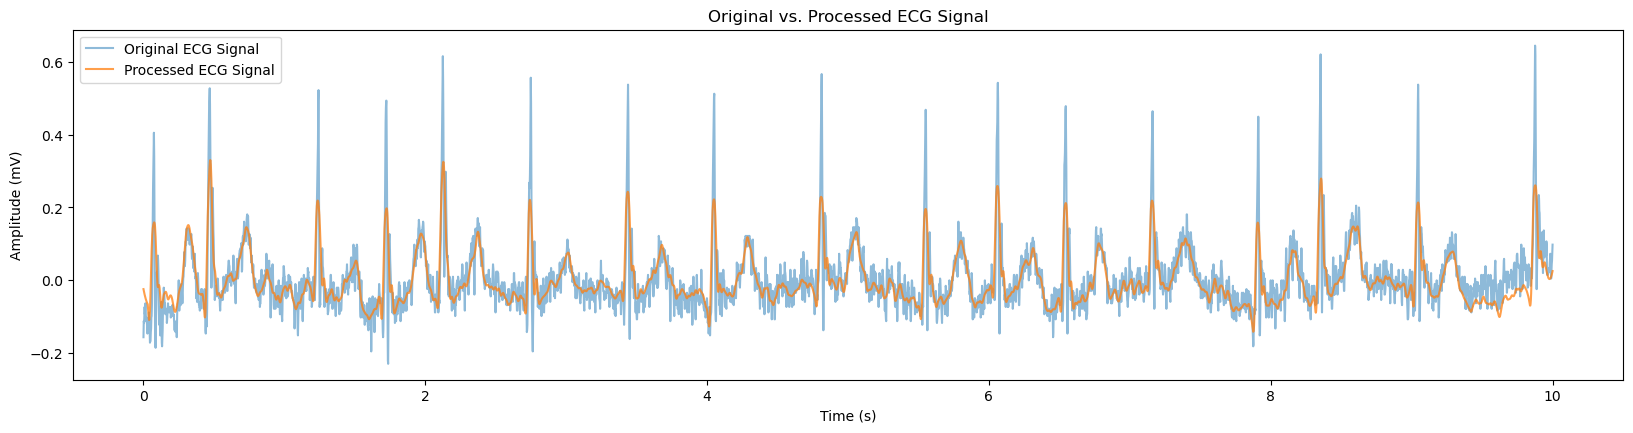

In [7]:
# Testing
file_name = '../raw_data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/01/010/JS00007.mat'  # select file
data = scipy.io.loadmat(file_name)
ecg_data = data['val'][1, :]  # select lead

preprocessor = PreprocessSignal(ecg_data)

start, end = 0, 5000 # specify start and end points 
sampling_rate = 500

time_vector = np.linspace(start / preprocessor.sampling_rate, end / preprocessor.sampling_rate, end - start) # convert indices to time (s)

# Original vs. Processed Signal
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(time_vector, preprocessor.original_signal[start:end] / 1000, label="Original ECG Signal", alpha=0.5)  # Convert μV to mV
plt.plot(time_vector, preprocessor.heart_signal[start:end] / 1000, label="Processed ECG Signal", alpha=0.75)  # Convert μV to mV
plt.title("Original vs. Processed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()